In [3]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#path = '/content/gdrive/My Drive/Colab Notebooks/707/Labs/'
#import sys
#sys.path.append(path)

In [4]:
# !pip install Box2D
# !pip install box2d-py
# !pip install gym[all]
# !pip install gym[Box_2D]
# !pip install torc
# !pip install -U "ray[rllib]" torch
import pickle as pkl
import gym 
env = gym.make("SpaceInvaders-ram-v0")

In [5]:
import ray
import ray.rllib.agents.dqn as dqn

def evaluation_fn(result):
    return result['episode_reward_mean']


def objective_fn(config):
    
    trainer = dqn.DQNTrainer(config=config)

    for i in range(2000):
        
      # Perform one iteration of training the policy with DQN
      result = trainer.train()
      intermediate_score = evaluation_fn(result)
      
      # Feed the score back back to Tune.
      tune.report(iterations=i, mean_reward=intermediate_score)
      

## Use DQN and train your algorithm on the Dungeon environment.

You can take inspiration from:
https://docs.ray.io/en/latest/rllib/rllib-training.html#basic-python-api

Experiment with the different parameters of the configuration:
https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#deep-q-networks-dqn-rainbow-parametric-dqn





In [6]:

import ray
import ray.rllib.agents.dqn as dqn
from ray.tune.logger import pretty_print
from ray import tune 

config = dqn.DEFAULT_CONFIG.copy()
config["dueling"] = tune.grid_search([True, False])
config["double_q"] = tune.grid_search([True, False])
config["model"] = { "fcnet_hiddens": [64, 32],
                    "fcnet_activation": 'relu',
    }
config["env"] = "SpaceInvaders-ram-v0"
#config['lr'] = tune.loguniform(1e-4, 1e-1),
config["gamma"] = tune.uniform(0, 1)

analysis = tune.run(
        objective_fn,
        metric="mean_reward",
        mode="max",
        num_samples=3,
        name='HP_tuning_Breakout',
        config=config,
        verbose=1)

print("Best hyperparameters found were: ", analysis.best_config)

2022-04-20 14:16:16,445	INFO tune.py:636 -- Total run time: 83998.13 seconds (83997.59 seconds for the tuning loop).


Best hyperparameters found were:  {'num_workers': 0, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 4, 'batch_mode': 'truncate_episodes', 'gamma': 0.7692580489277209, 'lr': 0.0005, 'train_batch_size': 32, 'model': {'fcnet_hiddens': [64, 32], 'fcnet_activation': 'relu'}, 'optimizer': {}, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env': 'SpaceInvaders-ram-v0', 'observation_space': None, 'action_space': None, 'env_config': {}, 'remote_worker_envs': False, 'remote_env_batch_wait_ms': 0, 'env_task_fn': None, 'render_env': False, 'record_env': False, 'clip_rewards': None, 'normalize_actions': True, 'clip_actions': False, 'preprocessor_pref': 'deepmind', 'log_level': 'WARN', 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>, 'ignore_worker_failures': False, 'log_sys_usage': True, 'fake_sampler': False, 'framework': 'tf', 'eager_tracing': False, 'eager_max_retraces': 20, 'explore': True, 'exploration_config': {'type':

In [7]:
print("Best hyperparameters found were: ", analysis.best_config)

Best hyperparameters found were:  {'num_workers': 0, 'num_envs_per_worker': 1, 'create_env_on_driver': False, 'rollout_fragment_length': 4, 'batch_mode': 'truncate_episodes', 'gamma': 0.7692580489277209, 'lr': 0.0005, 'train_batch_size': 32, 'model': {'fcnet_hiddens': [64, 32], 'fcnet_activation': 'relu'}, 'optimizer': {}, 'horizon': None, 'soft_horizon': False, 'no_done_at_end': False, 'env': 'SpaceInvaders-ram-v0', 'observation_space': None, 'action_space': None, 'env_config': {}, 'remote_worker_envs': False, 'remote_env_batch_wait_ms': 0, 'env_task_fn': None, 'render_env': False, 'record_env': False, 'clip_rewards': None, 'normalize_actions': True, 'clip_actions': False, 'preprocessor_pref': 'deepmind', 'log_level': 'WARN', 'callbacks': <class 'ray.rllib.agents.callbacks.DefaultCallbacks'>, 'ignore_worker_failures': False, 'log_sys_usage': True, 'fake_sampler': False, 'framework': 'tf', 'eager_tracing': False, 'eager_max_retraces': 20, 'explore': True, 'exploration_config': {'type':

In [13]:
# save analysis to file
with open("analysis_finalDFs_Atari.pkl", "wb") as f:
    pkl.dump(analysis.dataframe(), f)

with open("analysis_trialDFs_Atari.pkl", "wb") as f:
    pkl.dump(analysis.trial_dataframes, f)

with open("analysis_configs_Atari.pkl", "wb") as f:
    pkl.dump(analysis._configs, f)

In [9]:
df = analysis.dataframe(metric="mean_reward", mode="max")
df[['config/gamma', 'config/double_q', 'config/dueling', 'mean_reward']]

,config/gamma,config/double_q,config/dueling,mean_reward
0,0.769258,True,True,287.250000
1,0.443758,False,True,270.550000
2,0.791432,True,False,228.700000
3,0.244820,False,False,260.454545
4,0.180634,True,True,254.850000
5,0.947667,False,True,298.050000
6,0.492506,True,False,276.250000
7,0.705279,False,False,241.944444
8,0.132999,True,True,259.550000
9,0.147451,False,True,232.500000


In [10]:
list(analysis.trial_dataframes.values())[0]
list(analysis._configs.items())[2][1]['config/gamma']

0.7914320816416739

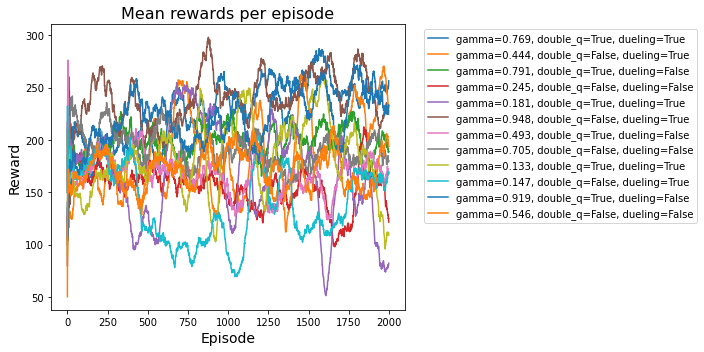

In [11]:
import matplotlib.pyplot as plt


# Plot mean rewards of all models
num_models = len(analysis.trial_dataframes.values())
fig, ax = plt.subplots(1,1,figsize=(10,5))

for i in range(num_models):
    trial_df = list(analysis.trial_dataframes.values())[i]

    gamma = list(analysis._configs.items())[i][1]['config/gamma']
    double_q = list(analysis._configs.items())[i][1]['config/double_q']
    dueling = list(analysis._configs.items())[i][1]['config/dueling']
    
    rewards = trial_df['mean_reward'] # Add this for moving average filter:   .rolling(window=5).mean()
    ax.plot(trial_df['mean_reward'], label="gamma={:.3f}, double_q={}, dueling={}".format(gamma, double_q, dueling))


ax.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title("Mean rewards per episode", fontsize=16)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Reward", fontsize=14)
plt.tight_layout()
plt.show()

https://docs.ray.io/en/latest/tune/api_docs/analysis.html

In [12]:
from ray.tune import ExperimentAnalysis
analysis_result = ExperimentAnalysis("~/ray_results/HP_tuning_LunarLander")

2022-04-20 14:16:17,385	INFO experiment_analysis.py:695 -- No `self.trials`. Drawing logdirs from checkpoint file. This may result in some information that is out of sync, as checkpointing is periodic.
